# D7046E Exercise 1 (ANN1)

This exercise has three taks where you will deepen your understanding of how artificial neural networks (ANNs) are implemented and trained. First, you will represent digits on an eight-segment display as vectors and hard-code perceptrons that classifies the digits. The purpose of this task is to better understand the basic computational units in ANNs and how inputs can be represented as feature vectors. Secondly, you will implement and train neural networks using [pytorch](https://pytorch.org/) on the seven-segment display data and the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset which you are familiar with from Exercise 0. Finally, you will implement a neural network including the forward (inference) pass and the backward (learning) pass from scratch using numpy. After completing these steps you will know the central building blocks of ANNs.

## Literature
Before starting with the implementation you should familiarize yourself with two additional chapters in the [deep learning book](https://www.deeplearningbook.org/). This will help you understand the theory behind neural networks and what mathematical formulas are important for the task. The lectures has touched on most of these concepts. Below is a list of recommended sections from the book. If you feel familiar with the contents of these sections, feel free to skip it.

* Chapter 6 - Deep feedforward networks
    - Section 6.0 - Discusses what do we mean by feedfoward networks and terminology such as input layer, output layer and hidden layer.
    - Section 6.2 - Discusses what gradient based learning is and what cost functions are.
    - Section 6.5 - Explains back propagation. Important here are the formulas 6.49 - 6.52.
* Chapter 8 - Optimization for Training Deep Models
    - Section 8.1.3 - Presents differences between batch (deterministic) and mini-batch (stochastic) algorithms.
    
## Libraries

Before starting with the implementations you need to import the following libraries.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy
import copy

from torch.utils.data import random_split

## Task 1

Classification of seven-segment display numbers with perceptrons. A [seven-segment display](https://en.wikipedia.org/wiki/Seven-segment_display) can be used to display digits by turning the different segments (A,B,C,D,E,F, G) on or off. Your task is to design ten different perceptrons (which together make a single-layer neural network with 10 outputs) that recognizes the ten different digits (0,1,2,3, ... ,9) represented by a seven-segment display. The input to each perceptron will be a seven-dimensional vector {A,B,C,D,E,F,G} where A is 1 if segment A is turned on and 0 otherwise (and the same for all the other segments).

![Seven Segment Display](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/7_Segment_Display_with_Labeled_Segments.svg/225px-7_Segment_Display_with_Labeled_Segments.svg.png)

This means that for each digit you should create a vector representing the digit, as well as a perceptron that selectively gives a high output for that particular digit and a low output for other digits. For each digit (0 to 9) the corresponding perceptron shoud have the greatest output value, indicating that it can correctly classify the corresponding digit/vector and thereby distinguish that digit from other digits.

For example, the digit 2 corresponds to the vector {1,1,0,1,1,0,1}. If the perceptron at index 2 (the third pereptron since we have a perceptron for 0 as well) gives the greatest output for this vector then this perceptron functions as desired. Similarly, other perceptrons should give the highest output for their corresponding vector.

For example, the digit zero is represented as segments A-F being on and segment G being off. The zero perceptron should reasonably have positive activation for A-F, say at a value of 1, and negative activation for G, say -1.

Why negative?

If we instead set the activation for G to 0, then there is no distinction between the digits zero and eight. Thus, our perceptron for zero would have the same output regardless of whether the input is zero or eight. You can address this with biases, so that the output for our eight-perceptron is higher than the zero-perceptron for input eight, and vice versa, but it makes balancing weights and biases much more difficult.

A good starting point is to consider which activations should be positive or negative, implement this, then check the output for all perceptrons for each digit and then contemplate the bias.


### Task 1.1

In this task you should use numpy rather than PyTorch to implement and understand the elementary arithmetic operations involved. After completing this exercise you should understand how an artificial neural network unit (like the perceptron) produces one scalar output from multiple input values, and how the trainable weights and biases determine the relation between input and output values of a neural network unit and layer.

Complete the input vectors, the weight vectors, and biases. Then update the prediction calculation (forward pass) to include bias in the calculation.

In [2]:
## First we need to define all the vectors corresponding to the various digits and add them to a list for easy access
# Please finish the list of digit vectors
x = [
    numpy.array([1,1,1,1,1,1,0]), # 0
    numpy.array([0,1,1,0,0,0,0]), # 1
    numpy.array([1,1,0,1,1,0,1]), # 2
    numpy.array([1,1,1,1,0,0,1]), # 3
    numpy.array([0,1,1,0,0,1,1]), # 4
    numpy.array([1,0,1,1,0,1,1]), # 5
    numpy.array([1,0,1,1,1,1,1]), # 6
    numpy.array([1,1,1,0,0,0,0]), # 7
    numpy.array([1,1,1,1,1,1,1]), # 8
    numpy.array([1,1,1,1,0,1,1]), # 9
]

# And we print one of the vectors to show you how to get a specific vector
print(f'Digit 5 corresponds to the vector {x[5]}')

Digit 5 corresponds to the vector [1 0 1 1 0 1 1]


In [3]:
## Second we need to create ten perceptron with weights and biases
# You also need to figure out which weights and biases to use for each perceptron
# We've already created some of the perceptrons for you, but you need to create the rest
# While we're using integers for our weight you can use floating point numbers (real numbers) as well if you want

weights = [
    numpy.array([1,1,1,1,1,1,-1]),      # 0
    numpy.array([-1,1,1,-1,-1,-1,-1]),  # 1
    numpy.array([1,1,-1,1,1,-1,1]),     # 2
    numpy.array([1,1,1,1,-1,-1,1]),     # 3
    numpy.array([-1,1,1,-1,-1,1,1]),    # 4
    numpy.array([1,-1,1,1,-1,1,1]),     # 5
    numpy.array([1,-1,1,1,1,1,1]),      # 6
    numpy.array([1,1,1,-1,-1,-1,-1]),   # 7
    numpy.array([1,1,1,1,1,1,1]),       # 8
    numpy.array([1,1,1,1,-1,1,1]),      # 9
]

biases = [
    0,  # 0
    1, # 1
    0,  # 2
    0,  # 3
    0,  # 4
    1,  # 5
    0,  # 6
    1,  # 7
    -1,  # 8
    0,   # 9
]

In [4]:
## Finally let's evaluate the output of the perceptrons.
# The line computing the output of each perceptron is not using bias, so you need to add that as well.
# If the perceptrons dont give the correct output then go back and edit the weights and biases in the
# previous cell (or check that the vectors are implemented correctly) until the outputs discriminate
# correctly between different digits. Remember to run a cell again (CONTROL + ENTER) if you update it.

debug = False # Set this to True if the predictions are wrong to get a more detailed output

for digit in range(10): # For each digit between 0 and 9 (range(n) gives a range (almost a list) of each number between 0 and n (excluding n)
    vector = x[digit] # Get the correct vector representation of the digit
    
    outputs = [] # Create an empty list to put the perceptrons' outputs in
    for w, b in zip(weights, biases): # For each weight and bias in the lists (zip takes two lists [x1,x2,...] [y1,y2,...] and makes a new list [(x1,y1),(x2,y2),...]) 
        
        # CHANGE THIS LINE TO ADD BIASES AS WELL
        output = w.dot(vector) + b # Calculating the output of the perceptron with weight w and bias b
        
        outputs.append(output) # Adding the output to the list of outputs
    prediction = outputs.index(max(outputs)) # Get prediction by taking the index of the output value with maximum input
    
    print(f'Digit {digit} was predicted to be {prediction}') # This is an f-string with notation f'text {variable1} more text {variable2}'
    
    if debug: # If debug is True
        print(f'Outputs for all perceptrons for the digit {digit}: {outputs}')
        print() # Add a newline for formating

Digit 0 was predicted to be 0
Digit 1 was predicted to be 1
Digit 2 was predicted to be 2
Digit 3 was predicted to be 3
Digit 4 was predicted to be 4
Digit 5 was predicted to be 5
Digit 6 was predicted to be 6
Digit 7 was predicted to be 7
Digit 8 was predicted to be 8
Digit 9 was predicted to be 9


### Task 1.2

Next you will train a classifier for the seven-segment display digits using PyTorch, much like you did in Exercise 0 with another dataset. The goal is to learn the weights and biases to correctly classify the digits of a seven-segment display. For this task you have the data needed via the first task above. 

Create the network using the PyTorch model [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), which you can find more information about in the [PyTorch documentation](https://pytorch.org/docs/stable/index.html). Whenever you encounter a new PyTorch function or class it's helpful to look it up in the documentation. If you wonder whether a particular machine learning feature exists in PyTorch you can also search in the documentation, or use the more brute force method of web search or asking an artificial intelligence for further information (see the discussion forum about AI in Canvas for further information). 

In [5]:
## Data and labels
# You don't need to edit this code, we simply show you how, in this case, we create the data and labels we need

# A matrix (or vector) in PyTorch is usually represented by a Tensor
# Create a Tensor with our digit vectors
data = torch.Tensor(x) # A Tensor can be created by simply giving it a nested numpy array/list of numbers as input
data = data.detach() # Since we won't be chaning the data during training we detach the Tensor from the computation graph

# Our labels will be the expected outputs of each perceptron for each digit
# This means we can't simply say "5" is our expected output, but rather that we want [0,0,0,0,0,1,0,0,0,0]
# This is called one-hot encoding where we have a vector where the value is one at the given index and zero everywhere else
# Since a matrix with one-hot representations of the corresponding index is simply an identity matrix, we use that as our labels
labels_train_raw = torch.eye(10) # Get a matrix with one-hot representations of each digit in each row (an identity matrix)
labels_train_raw = labels_train_raw.detach() # Since we won't be changing the labels during training we detach the Tensor from the computation graph

C:\Users\hanne\AppData\Local\Temp\ipykernel_7208\456315060.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  data = torch.Tensor(x) # A Tensor can be created by simply giving it a nested numpy array/list of numbers as input


In [6]:
## The network
# We create a simple network from torch.nn.Linear

input_size = 7 # What is the size of the input vector to the network?: # digits in 7-segment display
output_size = 10 # What is the size of the output vector of the network?: # possible digits to display

network = torch.nn.Linear(input_size, output_size) # Creating a single linear layer of a neural network with the given input and output sizes

Epoch 10 - Loss: 0.11073599010705948
Epoch 20 - Loss: 0.0756305381655693
Epoch 30 - Loss: 0.060341592878103256
Epoch 40 - Loss: 0.05201854184269905
Epoch 50 - Loss: 0.04674256220459938
Epoch 60 - Loss: 0.04303735867142677
Epoch 70 - Loss: 0.0402439646422863
Epoch 80 - Loss: 0.03802983835339546
Epoch 90 - Loss: 0.03621124476194382
Epoch 100 - Loss: 0.03467899188399315


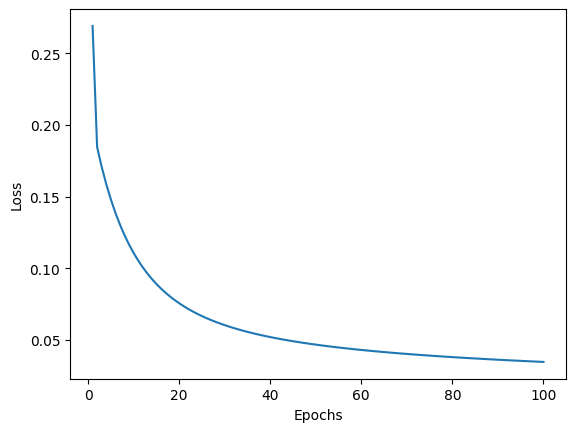

In [7]:
## Training the network
# You don't need to edit this code, we have given you the training loop to train the network

epochs = 100 # How many epochs (complete runs of the data) to train for. Since our dataset is small 100 seems reasonable
loss_function = torch.nn.MSELoss() # What function to use to calculate the loss given the prediction and labels
optimizer = torch.optim.SGD(network.parameters(), lr=1) # Function for updating the parameters of the network based on loss
learning_rate = 1 # How fast to optimize the network. Since our problem is quite small we can have a large learning rate, otherise 0.01 is usually standard

# Create a list to keep track of how the loss changes
losses = []

# For each epoch
for epoch in range(epochs):
    
    # Predict for each vector what digit they represent
    prediction = network(data)
    
    # Calculate the loss of the prediction by comparing to the expected output
    loss = loss_function(prediction, labels_train_raw)

    # Backpropogate the loss through the network to find the gradients of all parameters
    loss.backward()

    # Update the parameters along their gradients
    optimizer.step()

    # Clear stored gradient values
    optimizer.zero_grad()

    # Add the loss to the total epoch loss (item() turns a PyTorch scalar into a normal Python datatype)
    losses.append(loss.item())

    #Print the epoch and loss every 10 epochs
    if epoch % 10 == 9:
        print(f'Epoch {epoch+1} - Loss: {loss}')
    
# Plot the training loss per epoch
plt.plot(range(1,epochs+1),losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Task 1.3: Check the solution

Execute the cell below to see whether the network managed to learn to make the correct predictions.
Can you figure out what the learned weights and biases are, and how similar they are to your hardcoded solutions in the first task?

In [8]:
## Testing the trained network
# You don't need to edit this code

with torch.no_grad(): # Since we're not training we don't want to calculate the gradients for this prediction
    prediction = network(data) # Let's make one final prediction of the data

for digit in range(10):
    print(f'Digit {digit} was predicted to be {torch.argmax(prediction[digit])}') # argmax gets the index with the greatest value

Digit 0 was predicted to be 0
Digit 1 was predicted to be 1
Digit 2 was predicted to be 2
Digit 3 was predicted to be 3
Digit 4 was predicted to be 4
Digit 5 was predicted to be 5
Digit 6 was predicted to be 6
Digit 7 was predicted to be 7
Digit 8 was predicted to be 8
Digit 9 was predicted to be 9


## Task 2

While it is unnecessary to use machine learning to develop classifiers for a seven-segment display there are many other datasets for which it is difficult, if not impossible, to engineer such solutions without data-driven training/optimization of a model. For example, we have no generally useful and efficient method enabling us to write a program that can tell the difference between images of cats and dogs. However, we can easily gather many images of each, label the images, and use the resulting dataset to train a neural network that solves the task. A central problem in machine learning is how to define and train such a model to obtain maximum performance on new data which has not been used to optimize the model, referred to as the generalization of the model. Another important problem in machine learning is to minimize the computational cost of training and using such models.
 
Next you will extend the work started in Exercise 0 by developing a 2-layer neural network for classification of the MNIST dataset. MNIST consist of 70,000 grayscale images of handwritten digits that are 28x28 pixels each. Our goal is to train a 2-layer network that can recognize what digit an image represents. The subtasks are

* Implementation of a 2 layer NN (very similar to ex0)
* Training of this 2 layer NN (once again, very similar to ex0)
* Validation of the network during training (requires splitting the training set)
    - Save the model which performs the best on the validation data
* Graph the training loss vs validation loss
* You should obtain at least 85% accuracy on the test data (remember to load the best performing model before performing the accuracy test)

The code below loads the dataset (downloads it if necessary) and displays one of the images. You have to modify this code to complete this task.

In [9]:
# Define the mini-batch size
batch_size = 1000

# Download the dataset and create the dataloaders
mnist_train_raw = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train_raw, batch_size=batch_size, shuffle=False)

mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")
    plt.show()

images_train_raw, labels_train_raw = next(iter(train_loader))
images_test, labels_test = next(iter(test_loader))

### Task 2.1

Implement a 2-layer neural network using pytorch as well as a procedure for training and testing it. The training protocol should include both training and validation. Thus you need to split the training data into a training set (for which the error is backpropagated to update the parameters) and a validation set (which will not be used to directly update the model parameters, and instead be used to keep track of how good the model is at unseen data). 

The weights of the model which performs the best on the validation data should be stored and then be used for the final check on the test set. Validation sets are often created by taking a fraction of the training data (often, but not always, around 20%) at random. In Pytorch you might want to use [random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) for this. Using random split would require you to edit the way the Dataloaders are created.

You are free to choose any optimizer and loss function. Just note that some loss functions require the labels to be 1-hot encoded. As you will not use convolutional layers for this exercise (will be introduced later in the course), the inputs need to be transformed to 1d tensors (see [view](https://pytorch.org/docs/stable/tensors.html?highlight=view#torch.Tensor.view)).

**GOAL:** You should evaluate the network from the epoch with best validation score (early stopping) on the test set aiming to reach at least 85% accuracy.

**Remember** to run all your code before grading so that the teacher doesn't have to wait around for long training runs. Plot the training and validation losses for each epoch.

*Hint:* Validation and Testing loops are very similar to training except they don't use backpropagation. Additionally testing should only be performed once, while validation should be performed continually to make sure training is proceeding as intended and to save the parameters of the best epoch.

*Hint:* Storing the best model is more difficult than just assigning it to a variable as this only means you have two variables referencing the same network instance in memory (not a copy of the best betwork and one containing the current network). Instead you ned to make a copy of the network which can be achived with [deepcopy](https://docs.python.org/3/library/copy.html). Other ways to store models include saving them as a file which can be done with [torch.save](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

*Hint:* Everytime you train a network with random parameter initialization and random batches you get networks with different performance. Sometimes just running the training again can be enough to get a better result. However, if you do this too many times you run the risk of training (overfitting) on the test set.

In [10]:
best_network = None
losses = []

# Layer sizes and layout using same reasoning as in exc0
mnist_network = torch.nn.Sequential(
    nn.Linear(784, 100), nn.ReLU, nn.Linear(100, 10)
) 
epochs = 100 
loss_function = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(network.parameters(), lr=1) 
learning_rate = 1 

for epoch in range(epochs):
    prediction = mnist_network(data)                      # Run train data
    loss = loss_function(prediction, labels_train_raw)    # Get loss
    loss.backward()                                       # Backpropagate
    optimizer.step()                                      # Update parameters
    optimizer.zero_grad()                                 # Clear old gradients
    losses.append(loss.item())                            # Store loss function over time

    # Validation step; do not update gradients
    with torch.no_grad:
        validation = 
        print(f'Epoch {epoch+1} - Loss: {loss}')


# Test accuracy; get predictions withput gradient upgrade
with torch.no_grad:
    preds = mnist_network(mnist_test)

SyntaxError: invalid syntax (1839982367.py, line 23)

## Task 3

Implement a 2-layer neural network like above, but now without using a high-level machine learning library like pytorch. The network should function in the same way as the network in Task 2. The code block below contains code to change the training data from the DataLoader format to the "raw" numpy format. It also contains some comments to guide you in the right direction. The substasks involved are

* Implementation of a 2 layer NN using numpy
* Training and validation of the 2 layer NN
    - Once again, save the best performing model (can be done in memory)
* Graph the training vs validation loss
* At least 50% accuracy on the validation data (can be hard to get high accuracy)

**Note that the solution does not need to be fast/scalable, thus it is OK to develop a custom solution with, e.g., two explicit weight matrix variables representing the two layers.**

### The foward pass
This is easy. Recall that each differnt layer is calculated by the formula: 
$$ y = g(\mathbf{W}*\mathbf{x} + b) $$
where $W$ is the weight matrix, $x$ the input, $b$ the bias and $g$ the non-linearity. For this exercise you are allowed to put $b = 0$ for simplicity when calculating the backwards pass.

### Backward pass
This can be tricky. In canvas there is lecture material which explains back propogation and all the maths behind it. It should be under *Modules > Artificial Neural Networks (ANN) - Part 1 > Lecture: Backpropagation derivation.mp4*. This, the supplementary material for the lecture, together with the course book should be enough material for you to be able to implement the training algorithm.

### Weight update
Once you have calculated the gradient of both weight matrixes, this is updated by:
$$ W_i = W_i - \gamma \dfrac{dL}{dW_i} $$
where $\gamma$ is the step size, or learning rate.

***Remember*** to run all your code before grading so the teacher doesn't have to wait around for long training runs.

SyntaxError: expected ':' (2584139151.py, line 20)

## Optional programming challenge
You have now implemented a 2-layer neural network from scratch! Use this new gained knowledge to create an implementation where we can create and train a network with an arbitrary number of layers and units in each layer. This means that we should be able to specify the structure of the network and then train it using backpropagation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

def np_ReLU(x):
    return np.maximum(0, x)

def np_der_ReLU(x):
    if x == 0: raise Exception("ReLU derivative is undefined @ x = 0")
    return 1 if x > 0 else 0

epochs = 10  # Set the number of epochs to train for
D_in = 784   # Input size, images are 28x28 = 784 element vectors
D_out = 10   # Output size, 10 digit classes
H1 = 100     # Hidden layer size
gamma = 1e-5 # Learning rate

# Define network with one hidden layer, random initial weights
w1 = np.random.randn(D_in, H1)
w2 = np.random.randn(H1, D_out)

# Training iterations
train_loss = []
val_loss = []
best_model = []

# Train for a number of epochs
for epoch in range(epochs):
    # Training by looping over training set
    for tr_in, tr_lab in ...:
        tr_in = tr_in.numpy()
        tr_lab = tr_lab.numpy()
        
        for i in range(batch_size):
            # iterate through the mini-batch and perform forward pass and backward pass
            x = tr_in[i].reshape((1, D_in))
            y = np.eye(10)[tr_lab[i]]    # 1-hot encoding

            # Forward pass
            # y = w2*(ReLU(w1*x))
            h = w1.dot(x)
            h_relu = np_ReLU(h)
            y_pred = w2.dot(h_relu)

            # Compute loss function, squared error
            mse = (np.square(y - y_pred)).mean(axis=0) # along axis = 0, row-wise
    
            # Compute gradients of square-error loss with respect to w1 and w2 using backpropagation
            Lp = None
            dLw2 = h_relu.T * Lp
            dLw1 = x.T * np_der_ReLU(x) * Lp * w2.T

            # Update weights (stochastic gradient descent)
            # Wi <- Wi - gamma * (dL/dWi)
            w1 = w1 - gamma * ( dLw1 )
            w2 = w2 - gamma * ( dLw2 )


    # Validate the model
    for val_in, val_lab in ...:
        x = val_in[i].reshape((1, D_in))
        y = np.eye(10)[val_lab[i]]

        # Forward pass (same as train)
        h = w1.dot(x)
        HTML_relu = np_ReLU(h)
        y_pred = w2.dot(h_relu)

        # No gradient update so stop here
        # Compute and log validation loss
        val_loss = 
        
# Plot training and validation loss

total = 0
correct = 0

# Calculate accuracy on one test batch

## End

You have now reached the end of ANN1. When you have completed and understood the task above please make sure that all results inluding plots have been computed and then schedule a meeting with a teacher. The teacher will then assess orally that you (the lab group) has completed the exercise and that you understand its essental elements.